# IMA203 -- TP de méthode de variationnelles

```yaml
Nom: Liyao JIAO
Date: 19 Jan, 2024
```

In [1]:
%load_ext autoreload
%autoreload 2

In [182]:
# -*- coding: utf-8 -*-
import numpy as np
import platform
import tempfile
import os
import matplotlib.pyplot as plt
from scipy import ndimage as ndi
# necessite scikit-image 
from skimage import io as skio

from skimage import img_as_float
from skimage import img_as_ubyte

# POUR LA MORPHO
from skimage.segmentation import watershed 
from skimage.feature import peak_local_max


import time


In [3]:
#%% fonctions utiles au TP
def appfiltre(u,K):
    """ applique un filtre lineaire (en utilisant une multiplication en Fourier) """

    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    out=np.real(ifft2(fft2(u)*fft2(K)))
    return out    

def degrade_image(im,br): 
    """degrade une image en lui ajoutant du bruit"""
    out=im+br*np.random.randn(*im.shape)
    return out

def  grady(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient en bas est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:-1,:]=-I[:-1,:]+I[1:,:]
    M[-1,:]=np.zeros((n,))
    return M

def  gradx(I):
    """ Calcule le gradient en y de l'image I, avec condition de vonnewman au bord
     i.e. l'image est symétrisée et le gradient a droite est nul"""
    
    (m,n)=I.shape
    M=np.zeros((m,n))
    M[:,:-1]=-I[:,:-1]+I[:,1:]
    M[:,-1]=np.zeros((m,))
    return M

def div(px,py): 
    """calcule la divergence d'un champ de gradient"""
    """ div= - (grad)^*, i.e. div est la transposee de l'operateur gradient"""
    (m,n)=px.shape 
    assert px.shape==py.shape , " px et py n'ont pas la meme taille dans div"
    Mx=np.zeros((m,n))
    My=np.zeros((m,n))
    
    My[1:-1,:]=py[1:-1,:]-py[:-2,:]
    My[0,:]=py[0,:]
    My[-1,:]=-py[-2,:]
    
    Mx[:,1:-1]=px[:,1:-1]-px[:,:-2]
    Mx[:,0]=px[:,0]
    Mx[:,-1]=-px[:,-2]
    return Mx+My

def gradient_TV(v,u,lamb):
    """ calcule le gradient de la fonctionnelle E2 du TP"""
# on n'utilise pas gradx et grady car pour minimiser 
# la fonctionnelle E2 par descente de gradient nous avons choisi 
# de prendre les memes conditions au bords que pour la resolution quadratique
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Kxback=np.zeros((sy,sx))
    Kyback=np.zeros((sy,sx))
    Kxback[0,0]=-1
    Kxback[0,-1]=1
    Kyback[0,0]=-1
    Kyback[-1,0]=1

    Dx=appfiltre(u,Kx)
    Dy=appfiltre(u,Ky)
    ng=(Dx**2+Dy**2)**0.5+1e-5
    div=appfiltre(Dx/ng,Kxback)+appfiltre(Dy/ng,Kyback)
    return 2*(u-v)-lamb*div

def gradient_TV_nonperiodique(v,u,lamb):
     """ calcule le gradient de la fonctionnelle E2 du TP"""
     gx=gradx(u)
     gy=grady(u)
     ng=((gx**2)+(gy**2))**0.5+1e-5
     dive=div(gx/ng,gy/ng)
     return 2*(u-v)-lamb*dive
     

def resoud_quad_fourier(K,V):
    """trouve une image im qui minimise sum_i || K_i conv im - V_i||^2
     ou les K_i et les Vi sont des filtres et des images respectivement """
     
    n=len(K)
    assert len(K) == len(V) , "probleme de nombre de composantes dans resoud_quad"
    (sy,sx)=K[0].shape
    numer=np.vectorize(np.complex_)(np.zeros((sy,sx)))
    denom=np.vectorize(np.complex_)(np.zeros((sy,sx)))
    fft2=np.fft.fft2
    ifft2=np.fft.ifft2
    for k in range(n):
        fV=fft2(V[k])
        fK=fft2(K[k])
        #print('type de fV',fV.dtype,' type de fK',fK.dtype)
        numer+=np.conj(fK)*fV
        denom+=abs(fK)**2
    return np.real(ifft2(numer/denom))

def minimisation_quadratique(v,lamb):
    """ minimise la fonctionnelle E1 du TP"""
    (sy,sx)=v.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    delta=np.zeros((sy,sx))
    delta[0,0]=1.0
    s=lamb**0.5
    K=(s*Kx,s*Ky,delta)
    V=(np.zeros((sy,sx)),np.zeros((sy,sx)),v)
    return resoud_quad_fourier(K,V)

def norme_VT(I): 
    """ renvoie la norme de variation totale de I"""
    (sy,sx)=I.shape
    Kx=np.zeros((sy,sx))
    Ky=np.zeros((sy,sx))
    Kx[0,0]=1
    Kx[0,1]=-1
    Ky[0,0]=1
    Ky[1,0]=-1
    Dx=appfiltre(I,Kx)
    Dy=appfiltre(I,Ky)
    ng=(Dx**2+Dy**2)**0.5
    return ng.sum()

def norme_VT_nonperiodique(u):
    gx=gradx(u)
    gy=grady(u)
    ng=((gx**2)+(gy**2))**0.5
    return ng.sum()

def norm2(x):
    return ((x**2).sum())**0.5

def E2_nonperiodique(u,v,lamb): # renvoie l'énergie E2
    return lamb*norme_VT_nonperiodique(u)+norm2(u-v)**2


def minimise_TV_gradient(v,lamb,pas,nbpas):
    """ minimise E2 par descente de gradient a pas constant """
    u=np.zeros(v.shape)
    Energ=np.zeros(nbpas)
    for k in range(nbpas):
        print(k)
        Energ[k]=E2_nonperiodique(u,v,lamb)
        u=u-pas*gradient_TV_nonperiodique(v,u,lamb)
    return (u,Energ)


def projection(I,a,itmax): 
    """ calcule la projection de I sur G_a
        G_a est le sous-gradient de TV en zero
        Comme vu dans le poly cette projection permet de resoudre le probleme
        de debruitage TV (E2)"""
    # ici on utilise les conditions au bord de von neuman 
    # i.e. on utilise gradx et grady definis plus haut et non pas une convolution circulaire
    (m,n)=I.shape
    t=0.1249
    px=np.zeros((m,n))
    py=np.zeros((m,n))
    un=np.ones((m,n))
    
    for it in range(itmax):
        N=div(px,py)-I/a
        Gx=gradx(N)
        Gy=grady(N)
        G=(Gx**2+Gy**2)**0.5
        pxnew=(px+t*Gx)/(un+t*G)
        pynew=(py+t*Gy)/(un+t*G)
        px=pxnew
        py=pynew
    # la projection est la divergence du champ px,py
    P=a*div(px,py)
    return P                

def vartotale_Chambolle(v,lamb,itmax=100):
    """ Trouve une image qui minimise lamb*TV(I)+||I-v||^2 
    en utilisant la projection dur G_a"""
    (m,n)=v.shape
    P=projection(v,lamb/2,itmax)
    return v-P


def imread(fichier):
    return np.float32(skio.imread(fichier))


---
---

In [20]:
GRAY_f = {
    "cmap": "gray",
    "vmin": 0,
    "vmax": 1 
}

GRAY_b = {
    "cmap": "gray",
    "vmin": 0,
    "vmax": 255 
}


In [21]:
#%% lire une image
im = skio.imread("./lena.tif")
im = img_as_ubyte(im)


In [22]:
imb=degrade_image(im,25)

Text(0.5, 1.0, 'BRUITEE')

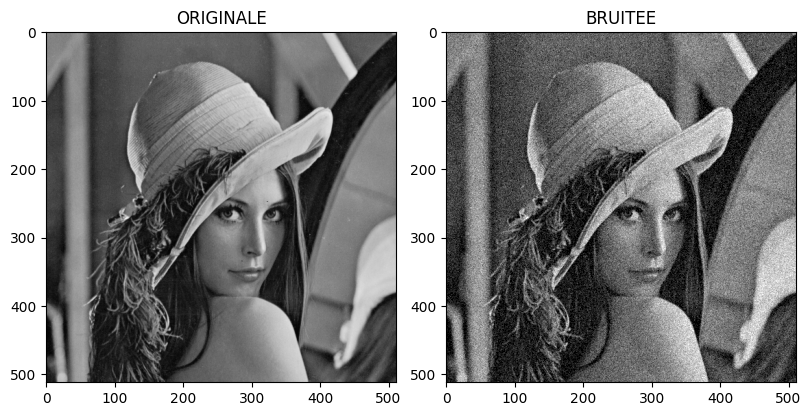

In [23]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITEE")

## 1. Débruitage par régularisation quadratique

## 1.1 Comment utiliser l’outil resoud_quad_fourier pour trouver le minimiseur de cette énergie (voir le programme minimisation_quadratique) ?

In [27]:
lamb=0.1
restau=minimisation_quadratique(imb,lamb)

Text(0.5, 0.98, "Un exemple de l'utilisation de minimisation_quadratique")

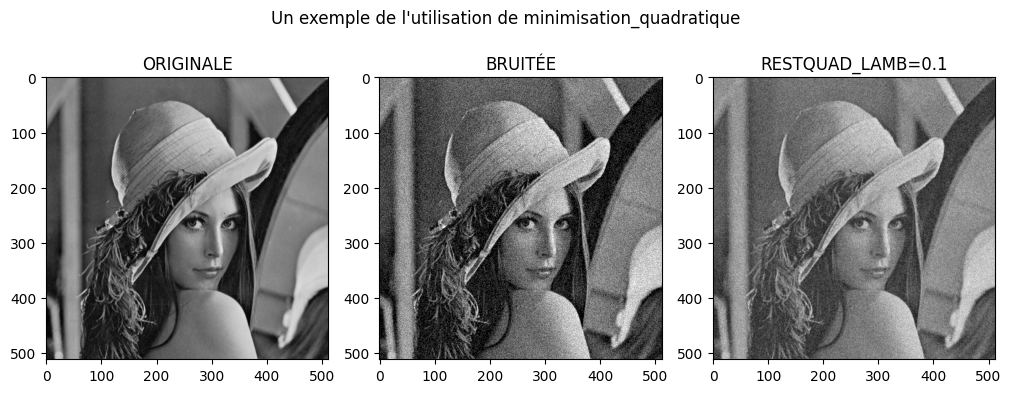

In [19]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITÉE")

ax = axsf[2]
ax.imshow(restau, cmap="gray")
ax.set_title(f"RESTQUAD_LAMB={lamb}")

fig.suptitle("Un exemple de l'utilisation de minimisation_quadratique")

**resoud_quad_fourier :**

- L'opération de convolution dans le domaine spatial est équivalente à une multiplication dans le domaine fréquentiel. 

- K[0]: Convolution de différenciation horizontale
- K[1]: Convolution de différenciation verticale
- K[2]: Convolution de passe bas.
- Additionner plusieurs résultats de convolution, normaliser, puis prendre la partie réelle


---

## 1.2 Décrire le résultat de ce débruitage lorsque λ est très grand ou très petit.

In [43]:
lamb_grand = 1e5
lamb_petit = 1e-5
restau_grand = minimisation_quadratique(imb,lamb=lamb_grand)
restau_petit = minimisation_quadratique(imb,lamb=lamb_petit)

Text(0.5, 0.98, 'LAMBs très grand et petit avec erreur norme2')

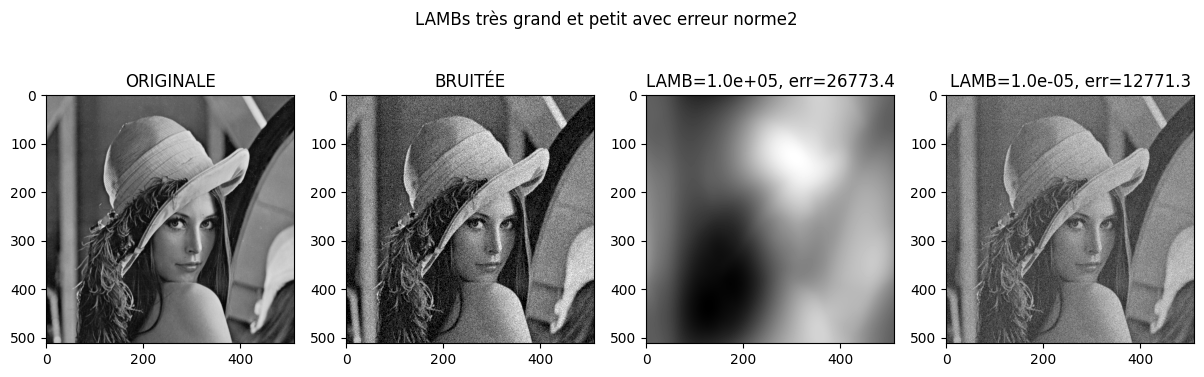

In [53]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITÉE")

ax = axsf[2]
ax.imshow(restau_grand, cmap="gray")
ax.set_title(f"LAMB={lamb_grand:.1e}, err={norm2(im-restau_grand):.1f}")

ax = axsf[3]
ax.imshow(restau_petit, cmap="gray")
ax.set_title(f"LAMB={lamb_petit:.1e}, err={norm2(im-restau_petit):.1f}")

fig.suptitle("LAMBs très grand et petit avec erreur norme2")

En comparant les images et les erreurs de norme 2, nous avons constaté que lorsque $\lambda$ est trop élevé, l'image devient trop lisse ; lorsqu'il est trop faible, l'effet d'élimination du bruit est insatisfaisant et la régularisation n'a pas d'effet.

---

## 1.3 

In [77]:
np.random.seed(42)
imb_5 = degrade_image(im,5)
imb_5_error = np.sum((imb_5 - im)**2)
print(imb_5_error)

6552213.749943607


In [78]:
im13_1 = minimisation_quadratique(imb_5, 1e-5)
im13_2 = minimisation_quadratique(imb_5, 1e5)

err13_1 = np.sum((im13_1 - im) ** 2)
err13_2 = np.sum((im13_2 - im) ** 2)


print(err13_1)

print(err13_2)

6551691.3570575155
716815949.1062456


In [79]:
left = 1e-5
right = 1e5
err = np.inf

while np.abs(err - imb_5_error) > 1e-2:
    lamb = (left + right) * 0.5
    tmp = minimisation_quadratique(imb_5, lamb=lamb)
    err = np.sum((tmp - im)**2)
    if  err < imb_5_error:
        left = lamb
    else:
        right = lamb

0.35755443100421447 0.3575544338463854
0.35755443100421447 6552213.748074217


In [82]:
print(f"Range: [left, right]")
print(f"lamb final ={lamb} avec err={err}")

Range: [left, right]
lamb final =0.35755443100421447 avec err=6552213.748074217


Text(0.5, 0.98, "LAMB avec erreur carré proche avec celui de l'image bruitée")

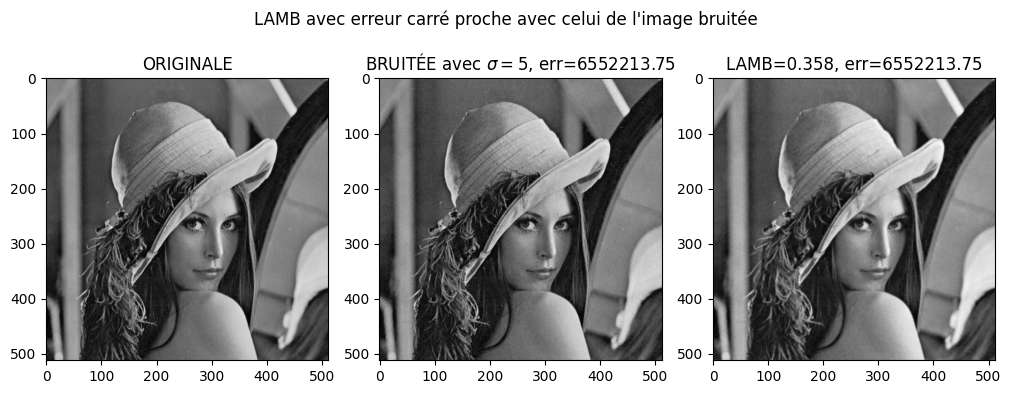

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb_5, **GRAY_b)
ax.set_title(f"BRUITÉE avec $\sigma=5$, err={imb_5_error:.2f}")

ax = axsf[2]
ax.imshow(tmp, cmap="gray")
ax.set_title(f"LAMB={lamb:.3f}, err={err:.2f}")

fig.suptitle("LAMB avec erreur carré proche avec celui de l'image bruitée")

---

## 1.4 Chercher le minimiseur

In [175]:
restaus = []
erreur = []
lambs = np.arange(0, 0.25, 0.01)

for k in lambs:
    restq = minimisation_quadratique(imb, 10**k)
    erreur.append(norm2(im - restq))

Text(0, 0.5, 'E1')

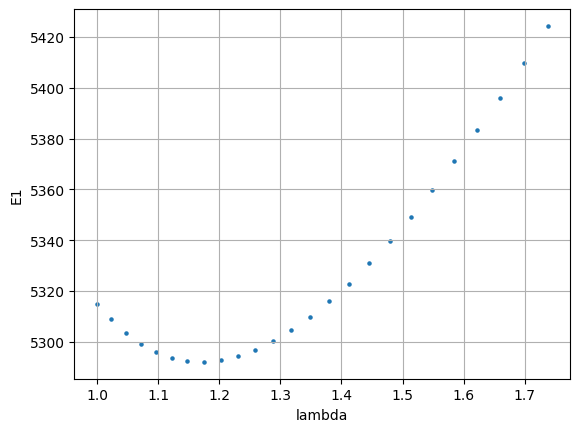

In [179]:

plt.scatter(10**lambs, erreur, s=5)
plt.grid()
plt.xlabel("lambda")
plt.ylabel("E1")

In [112]:
arrIndex = np.argmin(erreur)
lamb = 10 ** lambs[arrIndex]
print(f"lambda = {lamb} avec err = {erreur[arrIndex]}")

lambda = 1.1748975549395295 avec err = 5292.035477822405


In [113]:
res_minimale = minimisation_quadratique(imb, lamb)

Text(0.5, 0.98, 'Le minimale pour erreur de norme2')

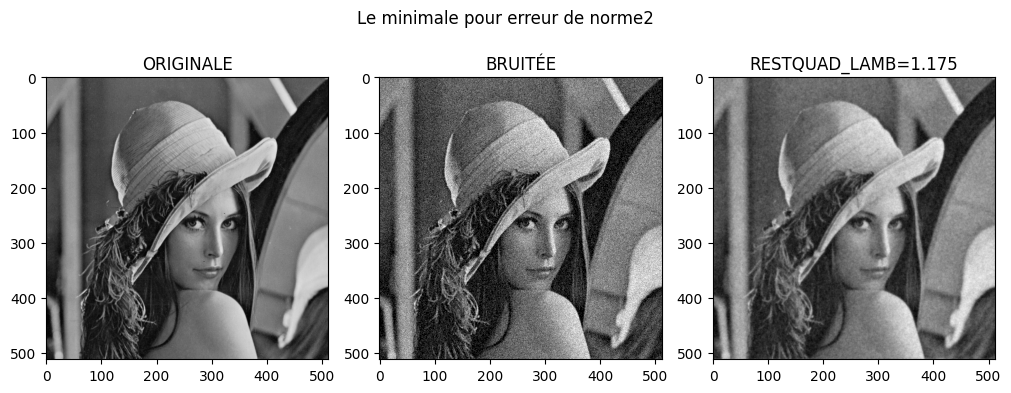

In [116]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITÉE")

ax = axsf[2]
ax.imshow(res_minimale, cmap="gray")
ax.set_title(f"RESTQUAD_LAMB={lamb:.3f}")

fig.suptitle("Le minimale pour erreur de norme2")

---
---

# 2 Débruitage par variation totale

## 2.1 Descente de gradient

In [117]:
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


In [135]:
def get_X_Y_U_V(energy):
    X = np.array(range(len(energy)))
    Y = np.array(energy)
    U = np.zeros(X.shape)
    V = np.zeros(Y.shape)
    U[:-1] = X[1:] - X[:-1]
    V[:-1] = Y[1:] - Y[:-1]
    return X, Y, U, V

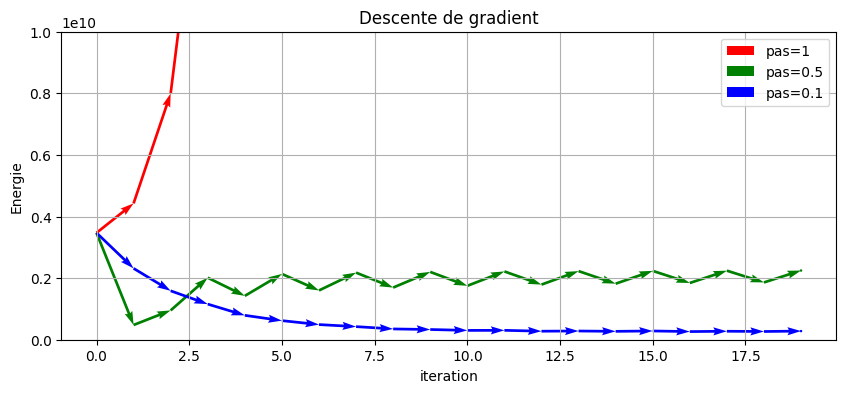

In [173]:
fig = plt.figure(figsize=(10, 4))

data = get_X_Y_U_V(en1)
plt.quiver(
    data[0], data[1], data[2], data[3], 
    scale=1, scale_units='xy', angles='xy', 
    headwidth=3, headlength=5, width=0.0035, color="red")

data = get_X_Y_U_V(en05)
plt.quiver(
    data[0], data[1], data[2], data[3], 
    scale=1, scale_units='xy', angles='xy', 
    headwidth=3, headlength=5, width=0.0035, color="green")

data = get_X_Y_U_V(en01)
plt.quiver(
    data[0], data[1], data[2], data[3], 
    scale=1, scale_units='xy', angles='xy', 
    headwidth=3, headlength=5, width=0.0035, color="blue")

plt.ylim([0, 1e10])

plt.legend(["pas=1", "pas=0.5", "pas=0.1"])
plt.xlabel("iteration")
plt.ylabel("Energie")
plt.title("Descente de gradient")
plt.grid()

Différentes longueurs de pas ont un impact significatif sur les résultats, l'effet est meilleur lorsque la longueur de pas est de 0.1

---

## 2.2 Projection Chambolle

In [186]:
tic = time.time()
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 10);
toc = time.time()
print(f"DG: {toc - tic:.4f}")


0
1
2
3
4
5
6
7
8
9
DG: 0.09


In [188]:
tic = time.time()
res = vartotale_Chambolle(v=imb, lamb=0.1, itmax=10)
toc = time.time()
print(f"Chambolle: {toc - tic:.4f}")



Chambolle: 0.0662


Text(0.5, 0.98, 'vartotale_Chambolle')

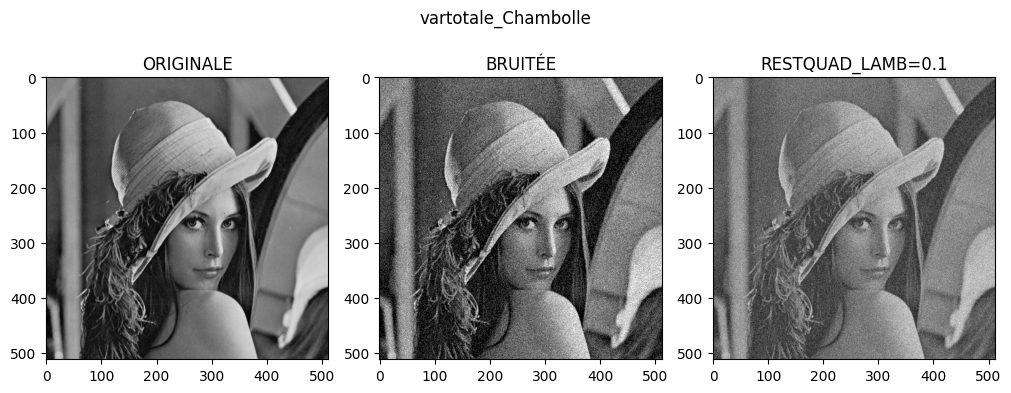

In [189]:
fig, axs = plt.subplots(1, 3, figsize=(10, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITÉE")

ax = axsf[2]
ax.imshow(res, cmap="gray")
ax.set_title(f"RESTQUAD_LAMB=0.1")

fig.suptitle("vartotale_Chambolle")

`vartotale_Chambolle` est plus rapide que `minimise_TV_gradient`

---
---

# 3 Comparaison

In [197]:
u01,en01=minimise_TV_gradient(imb, 40, 0.01, 1000);

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [202]:
norm2(u01 - im)

4407.416765205325

Text(0.5, 0.98, 'Comparaison de TV et DG')

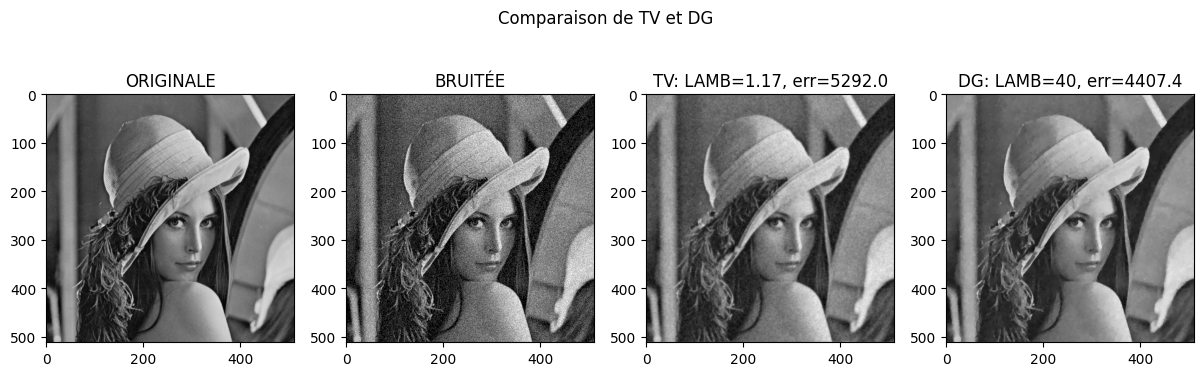

In [205]:
fig, axs = plt.subplots(1, 4, figsize=(12, 4), constrained_layout=True)
axsf = axs.flatten()
ax = axsf[0]
ax.imshow(im, **GRAY_b)
ax.set_title("ORIGINALE")

ax = axsf[1]
ax.imshow(imb, **GRAY_b)
ax.set_title("BRUITÉE")

ax = axsf[2]
ax.imshow(res_minimale, cmap="gray")
ax.set_title(f"TV: LAMB=1.17, err={norm2(im-res_minimale):.1f}")

ax = axsf[3]
ax.imshow(u01, cmap="gray")
ax.set_title(f"DG: LAMB=40, err=4407.4")

fig.suptitle("Comparaison de TV et DG")

---
---

# 4. Déconvolution avec variation totale

Cette partie est optionnelle et ne peut pas être terminée pendant le temps du
TP.

In [10]:
#%% COMPARAISON des methodes
# vous pouvez vous inspirer de ce qui suit pour trouver les meilleurs 
# parametres de regularisation 

errq=[]
errvt=[]
erreur=[]
vk=np.arange(0,0.25,0.01);
for k in vk: 
    print (k)
    #restq=minimisation_quadratique(imb,10^(k));
    #errq.append[]=norm2(restq-myim);
    #restva=vartotale_Chambolle(imb,10**(k));
    restq=minimisation_quadratique(imb,10**(k))
    erreur.append(norm2(im-restq))
    #errvt.append(norm2(restva-myim));
    


#plt.plot(10**vk,errvt);




0.0
0.01
0.02
0.03
0.04
0.05
0.06
0.07
0.08
0.09
0.1
0.11
0.12
0.13
0.14
0.15
0.16
0.17
0.18
0.19
0.2
0.21
0.22
0.23
0.24


In [ ]:
#%%
u1,en1=minimise_TV_gradient(imb, 40, 1, 20)
u05,en05=minimise_TV_gradient(imb, 40, 0.5, 20)
u01,en01=minimise_TV_gradient(imb, 40, 0.1, 20)
#u05inf,en05inf=minimise_TV_gradient(imb, 10, 0.5, 200)


In [ ]:
#%%
myim=imread('lena.tif')
imb=degrade_image(myim,25)
(u,energ)=minimise_TV_gradient(imb,1,0.1,100)   # pas = 0.1
(u,energ2)=minimise_TV_gradient(imb,1,1,100)       # pas = 1
plt.plot(energ)
plt.plot(energ2)
